# Optimization of CNN - TPE

In this notebook, we will optimize the hyperparameters of a CNN using the define-by-run model from Optuna.

In [1]:
# For reproducible results.
# See: 
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

import os
os.environ['PYTHONHASHSEED'] = '0'

import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

In [2]:
import itertools
from functools import partial

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.models import Sequential, load_model
from keras.optimizers import Adam, RMSprop

from tensorflow.keras.utils import to_categorical

In [4]:
import optuna

#  Data Preparation

The dataset contains information about images, each image is a hand-written digit. The aim is to have the computer predict which digit was written by the person, automatically, by "looking" at the image. 

Each image is 28 pixels in height and 28 pixels in width (28 x 28), making a total of 784 pixels. Each pixel value is an integer between 0 and 255, indicating the darkness in a gray-scale of that pixel.

The data is stored in a dataframe where each each pixel is a column (so it is flattened and not in the 28 x 28 format). 

The data set the has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

In [5]:
# Load the data

data = pd.read_csv("../mnist.csv")

# first column is the target, the rest of the columns
# are the pixels of the image

# each row is 1 image
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['label'], axis=1), # the images
    data['label'], # the target
    test_size = 0.1,
    random_state=0)

X_train.shape, X_test.shape

((37800, 784), (4200, 784))

Text(0, 0.5, 'Number of images')

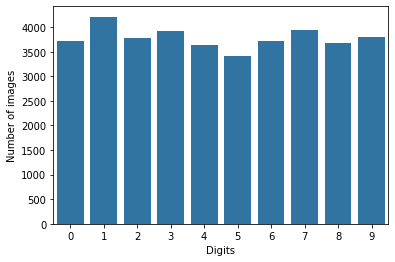

In [7]:
# number of images for each digit

g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

There are roughly the same amount of images for each of the 10 digits.

## Image re-scaling

We re-scale data for the CNN, between 0 and 1.

In [8]:
# Re-scale the data

# 255 is the maximum value a pixel can take

X_train = X_train / 255
X_test = X_test / 255

## Reshape

The images were stored in a pandas dataframe as 1-D vectors of 784 values. For a CNN with Keras, we need tensors with the following dimensions: width x height x channel. 

Thus, we reshape all data to 28 x 2 8 x 1, 3-D matrices. 

The 3rd dimension corresponds to the channel. RGB images have 3 channels. MNIST images are in gray-scale, thus they have only one channel in the 3rd dimension.

In [9]:
# Reshape image in 3 dimensions:
# height: 28px X width: 28px X channel: 1 

X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

## Target encoding

In [10]:
# the target is 1 variable with the 9 different digits
# as values

y_train.unique()

array([2, 0, 7, 4, 3, 5, 9, 6, 8, 1], dtype=int64)

In [11]:
# For Keras, we need to create 10 dummy variables,
# one for each digit

# Encode labels to one hot vectors (ex : digit 2 -> [0,0,1,0,0,0,0,0,0,0])

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

# the new target
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Let's print some example images.

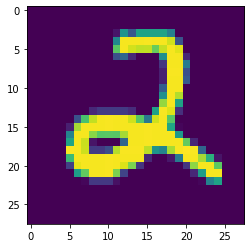

In [12]:
# Some image examples 

g = plt.imshow(X_train[0][:,:,0])

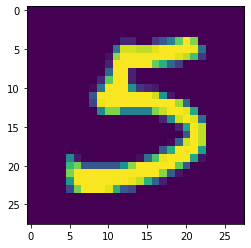

In [13]:
# Some image examples 

g = plt.imshow(X_train[10][:,:,0])

# Define-by-Run design

We create the CNN and add the sampling space for the hyperparameters as we go. This is the Desing-by-run concept.

In [14]:
# we will save the model with this name
path_best_model = 'cnn_model.keras'

# starting point for the optimization
best_accuracy = 0

In [15]:
# function to create the CNN

def objective(trial):

    # Start construction of a Keras Sequential model.
    model = Sequential()

    # Convolutional layers.

    # We add the different number of conv layers in the following loop:
    num_conv_layers = trial.suggest_int('num_conv_layers', 1, 3)

    for i in range(num_conv_layers):
        
        # NOTE: As per the below configuration, the parameters of each
        # convolutional layer will be identical.
        
        # if we want different parameters in each layer, check next
        # notebook

        model.add(Conv2D(
            filters=trial.suggest_categorical('filters', [16, 32, 64]),
            kernel_size=trial.suggest_categorical('kernel_size', [3, 5]),
            strides=trial.suggest_categorical('strides', [1, 2]),
            activation=trial.suggest_categorical(
                'activation', ['relu', 'tanh']),
            padding='same',
        ))

    # we could also optimize these parameters if we wanted:
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected Dense layer.
    model.add(Flatten())

    # Add fully-connected Dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    # We add the different number of layers in the following loop:

    num_dense_layers = trial.suggest_int('num_dense_layers', 1, 3)

    for i in range(num_dense_layers):

        # Add the dense fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes (neurons) and the activation function.
        model.add(Dense(
            units=trial.suggest_int('units', 5, 512),
            activation=trial.suggest_categorical(
                'activation', ['relu', 'tanh']),
        ))

    # Last fully-connected dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(10, activation='softmax'))

    # Use the Adam method for training the network.
    optimizer_name = trial.suggest_categorical(
        'optimizer_name', ['Adam', 'RMSprop'])

    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=trial.suggest_float('learning_rate',  1e-6, 1e-2))
    else:
        optimizer = RMSprop(
            learning_rate=trial.suggest_float('learning_rate',  1e-6, 1e-2),
            momentum=trial.suggest_float('momentum',  0.1, 0.9),
        )

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # train the model
    # we use 3 epochs to be able to run the notebook in a "reasonable"
    # time. If we increase the epochs, we will have better performance
    # this could be another parameter to optimize in fact.
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=3,
        batch_size=128,
        validation_split=0.1,
    )

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        # Training CNNs is costly, so we want to avoid having to re-train
        # the network with the best found parameters. We save it instead
        # as we search for the best hyperparam space.
        model.save(path_best_model)

        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    # The metric to optimize
    return accuracy

In [16]:
# we need this to store the search
# we will use it in the following notebook

study_name = "cnn_study"  # unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

In [17]:
study = optuna.create_study(
    direction='maximize',
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

study.optimize(objective, n_trials=30)

[I 2024-09-19 13:14:15,369] Using an existing study with name 'cnn_study' instead of creating a new one.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.6183 - loss: 1.3091 - val_accuracy: 0.8714 - val_loss: 0.4412
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 29s 92ms/step - accuracy: 0.8744 - loss: 0.4436 - val_accuracy: 0.8823 - val_loss: 0.4596
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.8913 - loss: 0.4157 - val_accuracy: 0.8926 - val_loss: 0.4025


[I 2024-09-19 13:15:34,481] Trial 2 finished with value: 0.8925926089286804 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 3, 'units': 423, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00794199051886489, 'momentum': 0.8058845535837492}. Best is trial 2 with value: 0.8925926089286804.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.7780 - loss: 0.6638 - val_accuracy: 0.9511 - val_loss: 0.1647
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9596 - loss: 0.1266 - val_accuracy: 0.9704 - val_loss: 0.1032
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9734 - loss: 0.0809 - val_accuracy: 0.9730 - val_loss: 0.0914


[I 2024-09-19 13:16:02,052] Trial 3 finished with value: 0.9730158448219299 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 36, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0021728551450702384, 'momentum': 0.6459788662507429}. Best is trial 3 with value: 0.9730158448219299.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 40s 72ms/step - accuracy: 0.1074 - loss: 3.2526 - val_accuracy: 0.1037 - val_loss: 2.4682
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.0984 - loss: 2.4344 - val_accuracy: 0.1037 - val_loss: 2.4963
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.0977 - loss: 2.4524 - val_accuracy: 0.1037 - val_loss: 2.5153


[I 2024-09-19 13:17:08,108] Trial 4 finished with value: 0.10370370000600815 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 5, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 3, 'units': 464, 'optimizer_name': 'Adam', 'learning_rate': 0.009619661309580531}. Best is trial 3 with value: 0.9730158448219299.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 33s 81ms/step - accuracy: 0.8258 - loss: 0.5331 - val_accuracy: 0.9683 - val_loss: 0.1083
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.9748 - loss: 0.0812 - val_accuracy: 0.9717 - val_loss: 0.0966
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.9848 - loss: 0.0479 - val_accuracy: 0.9849 - val_loss: 0.0578


[I 2024-09-19 13:19:05,826] Trial 5 finished with value: 0.9849206209182739 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 3, 'units': 267, 'optimizer_name': 'Adam', 'learning_rate': 0.0014096183159291828}. Best is trial 5 with value: 0.9849206209182739.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 677s 3s/step - accuracy: 0.1043 - loss: 2.9784 - val_accuracy: 0.1079 - val_loss: 2.3219
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 705s 3s/step - accuracy: 0.3464 - loss: 1.8508 - val_accuracy: 0.8966 - val_loss: 0.3420
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 784s 3s/step - accuracy: 0.9065 - loss: 0.3007 - val_accuracy: 0.8915 - val_loss: 0.3516


[I 2024-09-19 13:55:12,910] Trial 6 finished with value: 0.8915343880653381 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 5, 'strides': 1, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 331, 'optimizer_name': 'RMSprop', 'learning_rate': 0.003755115675475067, 'momentum': 0.28843212618402464}. Best is trial 5 with value: 0.9849206209182739.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 80s 245ms/step - accuracy: 0.5244 - loss: 1.4556 - val_accuracy: 0.9643 - val_loss: 0.1287
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 225ms/step - accuracy: 0.9575 - loss: 0.1521 - val_accuracy: 0.9487 - val_loss: 0.1906
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 67s 246ms/step - accuracy: 0.9690 - loss: 0.1144 - val_accuracy: 0.9722 - val_loss: 0.0997


[I 2024-09-19 13:59:00,367] Trial 7 finished with value: 0.9722222089767456 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 3, 'units': 254, 'optimizer_name': 'RMSprop', 'learning_rate': 0.007812248197962716, 'momentum': 0.1805758992467288}. Best is trial 5 with value: 0.9849206209182739.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 213s 736ms/step - accuracy: 0.0991 - loss: 5.2899 - val_accuracy: 0.1079 - val_loss: 3.5193
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 181s 675ms/step - accuracy: 0.0991 - loss: 3.3997 - val_accuracy: 0.1146 - val_loss: 3.1305
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 179s 670ms/step - accuracy: 0.1014 - loss: 3.3451 - val_accuracy: 0.1079 - val_loss: 3.0292


[I 2024-09-19 14:08:35,593] Trial 8 finished with value: 0.10793650895357132 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 3, 'strides': 1, 'activation': 'tanh', 'num_dense_layers': 1, 'units': 288, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0061761034059216, 'momentum': 0.882508230486145}. Best is trial 5 with value: 0.9849206209182739.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 36s 85ms/step - accuracy: 0.7856 - loss: 0.6722 - val_accuracy: 0.9302 - val_loss: 0.2400
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 23s 81ms/step - accuracy: 0.9418 - loss: 0.2296 - val_accuracy: 0.9307 - val_loss: 0.2672
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 22s 76ms/step - accuracy: 0.9410 - loss: 0.2405 - val_accuracy: 0.9439 - val_loss: 0.2799


[I 2024-09-19 14:09:59,376] Trial 9 finished with value: 0.9439153671264648 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 133, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0068396668729392394, 'momentum': 0.8574480903831776}. Best is trial 5 with value: 0.9849206209182739.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 623s 2s/step - accuracy: 0.8049 - loss: 0.9259 - val_accuracy: 0.9730 - val_loss: 0.0906
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 601s 2s/step - accuracy: 0.9805 - loss: 0.0644 - val_accuracy: 0.9614 - val_loss: 0.1275
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 579s 2s/step - accuracy: 0.9829 - loss: 0.0508 - val_accuracy: 0.9783 - val_loss: 0.0803


[I 2024-09-19 14:40:04,176] Trial 10 finished with value: 0.9783068895339966 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 1, 'units': 158, 'optimizer_name': 'Adam', 'learning_rate': 0.008976398573598934}. Best is trial 5 with value: 0.9849206209182739.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.8622 - loss: 0.4382 - val_accuracy: 0.9561 - val_loss: 0.1505
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.9702 - loss: 0.0936 - val_accuracy: 0.9728 - val_loss: 0.0969
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.9819 - loss: 0.0542 - val_accuracy: 0.9733 - val_loss: 0.1008


[I 2024-09-19 14:41:04,146] Trial 11 finished with value: 0.9732804298400879 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 1, 'activation': 'tanh', 'num_dense_layers': 1, 'units': 223, 'optimizer_name': 'Adam', 'learning_rate': 0.005737852816027761}. Best is trial 5 with value: 0.9849206209182739.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 38s 104ms/step - accuracy: 0.8101 - loss: 0.6973 - val_accuracy: 0.9566 - val_loss: 0.1465
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - accuracy: 0.9661 - loss: 0.1099 - val_accuracy: 0.9688 - val_loss: 0.1066
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - accuracy: 0.9807 - loss: 0.0644 - val_accuracy: 0.9701 - val_loss: 0.0988


[I 2024-09-19 14:42:39,799] Trial 12 finished with value: 0.9701058268547058 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 3, 'units': 381, 'optimizer_name': 'Adam', 'learning_rate': 0.00036479575756183987}. Best is trial 5 with value: 0.9849206209182739.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 520s 2s/step - accuracy: 0.8763 - loss: 0.3871 - val_accuracy: 0.9767 - val_loss: 0.0721
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 510s 2s/step - accuracy: 0.9839 - loss: 0.0522 - val_accuracy: 0.9817 - val_loss: 0.0699
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 537s 2s/step - accuracy: 0.9893 - loss: 0.0341 - val_accuracy: 0.9812 - val_loss: 0.0850


[I 2024-09-19 15:09:15,686] Trial 13 finished with value: 0.9812169075012207 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 1, 'units': 159, 'optimizer_name': 'Adam', 'learning_rate': 0.004032241956367687}. Best is trial 5 with value: 0.9849206209182739.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.8497 - loss: 0.5138 - val_accuracy: 0.9783 - val_loss: 0.0688
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.9835 - loss: 0.0515 - val_accuracy: 0.9807 - val_loss: 0.0796
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 365s 1s/step - accuracy: 0.9878 - loss: 0.0348 - val_accuracy: 0.9828 - val_loss: 0.0794


[I 2024-09-19 15:28:45,230] Trial 14 finished with value: 0.9828042387962341 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 1, 'units': 136, 'optimizer_name': 'Adam', 'learning_rate': 0.0035180177177428565}. Best is trial 5 with value: 0.9849206209182739.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 54s 175ms/step - accuracy: 0.7566 - loss: 0.7273 - val_accuracy: 0.9651 - val_loss: 0.1103
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 84s 181ms/step - accuracy: 0.9725 - loss: 0.0909 - val_accuracy: 0.9701 - val_loss: 0.1005
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 80s 172ms/step - accuracy: 0.9823 - loss: 0.0601 - val_accuracy: 0.9807 - val_loss: 0.0622


[I 2024-09-19 15:32:24,423] Trial 15 finished with value: 0.9806878566741943 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 2, 'units': 23, 'optimizer_name': 'Adam', 'learning_rate': 0.0015379711565592484}. Best is trial 5 with value: 0.9849206209182739.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 100s 354ms/step - accuracy: 0.8594 - loss: 0.4230 - val_accuracy: 0.9780 - val_loss: 0.0722
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 134s 324ms/step - accuracy: 0.9820 - loss: 0.0565 - val_accuracy: 0.9728 - val_loss: 0.0965
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 144s 328ms/step - accuracy: 0.9871 - loss: 0.0405 - val_accuracy: 0.9839 - val_loss: 0.0601


[I 2024-09-19 15:38:43,130] Trial 16 finished with value: 0.9838624596595764 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 2, 'units': 104, 'optimizer_name': 'Adam', 'learning_rate': 0.002875833232436467}. Best is trial 5 with value: 0.9849206209182739.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.8325 - loss: 0.5257 - val_accuracy: 0.9646 - val_loss: 0.1230
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.9764 - loss: 0.0780 - val_accuracy: 0.9738 - val_loss: 0.0886
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.9844 - loss: 0.0481 - val_accuracy: 0.9817 - val_loss: 0.0700


[I 2024-09-19 15:39:42,399] Trial 17 finished with value: 0.9817460179328918 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 2, 'units': 93, 'optimizer_name': 'Adam', 'learning_rate': 0.001643436142508294}. Best is trial 5 with value: 0.9849206209182739.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 179s 647ms/step - accuracy: 0.7642 - loss: 0.8231 - val_accuracy: 0.9598 - val_loss: 0.1364
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 172s 646ms/step - accuracy: 0.9717 - loss: 0.0941 - val_accuracy: 0.9725 - val_loss: 0.0874
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 182s 681ms/step - accuracy: 0.9817 - loss: 0.0581 - val_accuracy: 0.9794 - val_loss: 0.0721


[I 2024-09-19 15:48:36,456] Trial 18 finished with value: 0.9793650507926941 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 3, 'units': 218, 'optimizer_name': 'Adam', 'learning_rate': 0.00022183657977382443}. Best is trial 5 with value: 0.9849206209182739.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 112s 399ms/step - accuracy: 0.8744 - loss: 0.3844 - val_accuracy: 0.9807 - val_loss: 0.0746
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 135s 369ms/step - accuracy: 0.9834 - loss: 0.0559 - val_accuracy: 0.9841 - val_loss: 0.0598
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 99s 369ms/step - accuracy: 0.9904 - loss: 0.0315 - val_accuracy: 0.9839 - val_loss: 0.0722


[I 2024-09-19 15:54:22,966] Trial 19 finished with value: 0.9838624596595764 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 2, 'units': 319, 'optimizer_name': 'Adam', 'learning_rate': 0.0027029521896780677}. Best is trial 5 with value: 0.9849206209182739.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.8592 - loss: 0.4343 - val_accuracy: 0.9550 - val_loss: 0.1466
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.9696 - loss: 0.0991 - val_accuracy: 0.9648 - val_loss: 0.1212
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9830 - loss: 0.0537 - val_accuracy: 0.9653 - val_loss: 0.1197


[I 2024-09-19 15:54:56,448] Trial 20 finished with value: 0.9653438925743103 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 1, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 83, 'optimizer_name': 'Adam', 'learning_rate': 0.004720707118436746}. Best is trial 5 with value: 0.9849206209182739.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 114s 406ms/step - accuracy: 0.8369 - loss: 0.4920 - val_accuracy: 0.9762 - val_loss: 0.0759
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 108s 407ms/step - accuracy: 0.9823 - loss: 0.0592 - val_accuracy: 0.9804 - val_loss: 0.0715
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 109s 407ms/step - accuracy: 0.9866 - loss: 0.0417 - val_accuracy: 0.9728 - val_loss: 0.1045


[I 2024-09-19 16:00:28,983] Trial 21 finished with value: 0.9727513194084167 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 3, 'units': 504, 'optimizer_name': 'Adam', 'learning_rate': 0.0010526550916922462}. Best is trial 5 with value: 0.9849206209182739.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 61s 197ms/step - accuracy: 0.8465 - loss: 0.4705 - val_accuracy: 0.9765 - val_loss: 0.0796
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 50s 185ms/step - accuracy: 0.9809 - loss: 0.0624 - val_accuracy: 0.9823 - val_loss: 0.0698
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 84s 190ms/step - accuracy: 0.9859 - loss: 0.0440 - val_accuracy: 0.9698 - val_loss: 0.1024


[I 2024-09-19 16:03:43,956] Trial 22 finished with value: 0.9698412418365479 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 3, 'units': 209, 'optimizer_name': 'Adam', 'learning_rate': 0.002689245779371347}. Best is trial 5 with value: 0.9849206209182739.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 103s 368ms/step - accuracy: 0.8675 - loss: 0.3833 - val_accuracy: 0.9765 - val_loss: 0.0787
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 142s 367ms/step - accuracy: 0.9817 - loss: 0.0586 - val_accuracy: 0.9820 - val_loss: 0.0759
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 98s 366ms/step - accuracy: 0.9885 - loss: 0.0358 - val_accuracy: 0.9833 - val_loss: 0.0609


[I 2024-09-19 16:09:28,603] Trial 23 finished with value: 0.9833333492279053 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 2, 'units': 326, 'optimizer_name': 'Adam', 'learning_rate': 0.0027854827384414032}. Best is trial 5 with value: 0.9849206209182739.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 103s 368ms/step - accuracy: 0.8683 - loss: 0.3926 - val_accuracy: 0.9786 - val_loss: 0.0712
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 98s 365ms/step - accuracy: 0.9818 - loss: 0.0582 - val_accuracy: 0.9854 - val_loss: 0.0549
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 98s 365ms/step - accuracy: 0.9894 - loss: 0.0364 - val_accuracy: 0.9701 - val_loss: 0.1143


[I 2024-09-19 16:14:28,027] Trial 24 finished with value: 0.9701058268547058 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 2, 'units': 331, 'optimizer_name': 'Adam', 'learning_rate': 0.0027799425075864742}. Best is trial 5 with value: 0.9849206209182739.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 92s 326ms/step - accuracy: 0.8674 - loss: 0.4019 - val_accuracy: 0.9767 - val_loss: 0.0823
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 91s 342ms/step - accuracy: 0.9811 - loss: 0.0601 - val_accuracy: 0.9788 - val_loss: 0.0737
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 95s 357ms/step - accuracy: 0.9889 - loss: 0.0368 - val_accuracy: 0.9770 - val_loss: 0.0979


[I 2024-09-19 16:19:07,714] Trial 25 finished with value: 0.9769841432571411 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 2, 'units': 283, 'optimizer_name': 'Adam', 'learning_rate': 0.004428859079871755}. Best is trial 5 with value: 0.9849206209182739.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 31s 101ms/step - accuracy: 0.8554 - loss: 0.4776 - val_accuracy: 0.9701 - val_loss: 0.0993
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 27s 98ms/step - accuracy: 0.9766 - loss: 0.0737 - val_accuracy: 0.9733 - val_loss: 0.0904
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 26s 97ms/step - accuracy: 0.9872 - loss: 0.0429 - val_accuracy: 0.9812 - val_loss: 0.0629


[I 2024-09-19 16:20:32,992] Trial 26 finished with value: 0.9812169075012207 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 2, 'units': 387, 'optimizer_name': 'Adam', 'learning_rate': 0.0008556088799751187}. Best is trial 5 with value: 0.9849206209182739.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 105s 372ms/step - accuracy: 0.8647 - loss: 0.4096 - val_accuracy: 0.9775 - val_loss: 0.0781
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 134s 342ms/step - accuracy: 0.9827 - loss: 0.0550 - val_accuracy: 0.9757 - val_loss: 0.0821
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 96s 357ms/step - accuracy: 0.9886 - loss: 0.0371 - val_accuracy: 0.9820 - val_loss: 0.0688


[I 2024-09-19 16:26:08,456] Trial 27 finished with value: 0.9820106029510498 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 2, 'units': 187, 'optimizer_name': 'Adam', 'learning_rate': 0.0032512733066227756}. Best is trial 5 with value: 0.9849206209182739.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.8016 - loss: 0.6055 - val_accuracy: 0.9463 - val_loss: 0.1796
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9554 - loss: 0.1395 - val_accuracy: 0.9619 - val_loss: 0.1303
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9676 - loss: 0.1018 - val_accuracy: 0.9622 - val_loss: 0.1283


[I 2024-09-19 16:26:43,864] Trial 28 finished with value: 0.9621692895889282 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 257, 'optimizer_name': 'Adam', 'learning_rate': 0.0018835141800084595}. Best is trial 5 with value: 0.9849206209182739.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 42s 135ms/step - accuracy: 0.8554 - loss: 0.4230 - val_accuracy: 0.9770 - val_loss: 0.0897
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 35s 132ms/step - accuracy: 0.9791 - loss: 0.0738 - val_accuracy: 0.9778 - val_loss: 0.0865
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 41s 130ms/step - accuracy: 0.9844 - loss: 0.0589 - val_accuracy: 0.9852 - val_loss: 0.0751


[I 2024-09-19 16:28:43,886] Trial 29 finished with value: 0.9851852059364319 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 3, 'units': 364, 'optimizer_name': 'Adam', 'learning_rate': 0.005232847515447734}. Best is trial 29 with value: 0.9851852059364319.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.8586 - loss: 0.4333 - val_accuracy: 0.9741 - val_loss: 0.0893
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step - accuracy: 0.9789 - loss: 0.0764 - val_accuracy: 0.9712 - val_loss: 0.1066
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.9854 - loss: 0.0505 - val_accuracy: 0.9704 - val_loss: 0.1575


[I 2024-09-19 16:29:42,143] Trial 30 finished with value: 0.970370352268219 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 3, 'units': 376, 'optimizer_name': 'Adam', 'learning_rate': 0.005399567967815879}. Best is trial 29 with value: 0.9851852059364319.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.5853 - loss: 1.1604 - val_accuracy: 0.9347 - val_loss: 0.2342
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.9354 - loss: 0.2306 - val_accuracy: 0.9545 - val_loss: 0.1628
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.9507 - loss: 0.1765 - val_accuracy: 0.9534 - val_loss: 0.1830


[I 2024-09-19 16:30:15,640] Trial 31 finished with value: 0.9534391760826111 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 3, 'units': 427, 'optimizer_name': 'RMSprop', 'learning_rate': 0.006361119920457086, 'momentum': 0.43307825713979875}. Best is trial 29 with value: 0.9851852059364319.


# Analyze results

In [18]:
study.best_params

{'num_conv_layers': 2,
 'filters': 16,
 'kernel_size': 5,
 'strides': 1,
 'activation': 'relu',
 'num_dense_layers': 3,
 'units': 364,
 'optimizer_name': 'Adam',
 'learning_rate': 0.005232847515447734}

In [19]:
study.best_value

0.9851852059364319

Text(0, 0.5, 'Accuracy')

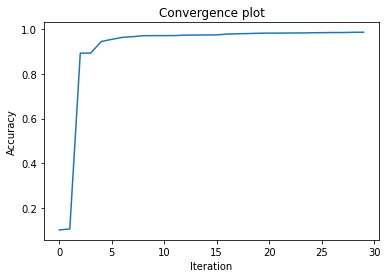

In [20]:
results = study.trials_dataframe()

results['value'].sort_values().reset_index(drop=True).plot()
plt.title('Convergence plot')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# Evaluate the model

In [21]:
# load best model

model = load_model(path_best_model)

In [22]:
model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_51 (Conv2D)                   │ (None, 28, 28, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_52 (Conv2D)                   │ (None, 28, 28, 16)          │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_27 (Flatten)                 │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ (None, 364)                 │       1,141,868 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 364)                 │         132,860 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 364)                 │         132,860 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_87 (Dense)                     │ (None, 10)                  │           3,650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,254,212 (16.23 MB)

 Trainable params: 1,418,070 (5.41 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,836,142 (10.82 MB)

In [23]:
# make predictions in test set

result = model.evaluate(x=X_test,
                        y=y_test)

132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9884 - loss: 0.0515


In [24]:
# print evaluation metrics

for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.0599006712436676
compile_metrics 0.9871428608894348


## Confusion matrix

In [25]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1)

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) 

cm

132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


array([[419,   0,   0,   0,   0,   0,   1,   0,   2,   0],
       [  0, 467,   0,   2,   0,   0,   1,   2,   1,   0],
       [  1,   0, 406,   1,   0,   0,   0,   1,   0,   0],
       [  0,   0,   0, 421,   0,   1,   0,   1,   1,   2],
       [  1,   1,   3,   0, 418,   0,   2,   2,   0,   2],
       [  0,   0,   0,   1,   0, 379,   2,   0,   0,   0],
       [  0,   0,   0,   0,   0,   1, 410,   0,   1,   0],
       [  0,   0,   2,   2,   0,   0,   0, 465,   0,   0],
       [  0,   0,   1,   1,   0,   0,   5,   0, 377,   0],
       [  4,   0,   0,   0,   3,   0,   1,   1,   1, 384]], dtype=int64)

Text(0.5, 13.421126458070312, 'Predicted label')

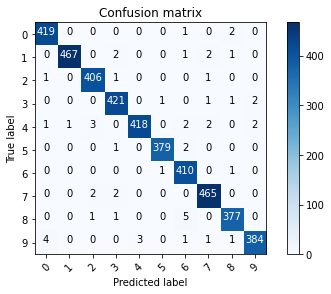

In [26]:
# let's make it more colourful
classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Here we can see that our CNN performs very well on all digits.